![](policecar.jpg)

# Traffic Violation In Maryland
<b>Henry Phan, Jason Lim</b>
<hr>

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import datetime
import statsmodels.formula.api as sm 

In [151]:
original = pd.read_excel('traffic_sample.xlsx')

In [152]:
# Converting the Latitude and Longitude Attributes to a Float
original["Latitude"] = original["Latitude"].astype(float)
original["Longitude"] = original["Longitude"].astype(float)

original = original[original["Gender"] != "U"]
original = original[(original["Year"] != 0) & (original["Year"] < 2020) & (original["Year"] > 1900)]

original.head(n = 25)

Unnamed: 0 Date Of Stop Time Of Stop Agency  \
0       415031   2016-05-01     23:08:00    MCP   
1       261574   2017-11-30     01:14:00    MCP   
2       523346   2012-05-24     10:48:00    MCP   
3       213661   2012-10-18     03:30:00    MCP   
4       330686   2012-02-16     07:47:00    MCP   
5       567779   2015-09-18     14:19:00    MCP   
6       767243   2014-09-05     01:26:00    MCP   
7       391162   2016-11-14     08:08:00    MCP   
8       399408   2016-05-07     21:17:00    MCP   
9       595871   2018-02-06     17:31:00    MCP   
10      854814   2015-10-20     17:10:00    MCP   
11       29623   2015-12-26     14:11:00    MCP   
12      786363   2014-12-11     04:58:00    MCP   
13      494721   2015-09-23     14:18:00    MCP   
14       19786   2016-03-12     08:02:00    MCP   
15      828227   2015-04-27     15:10:00    MCP   
16      746339   2015-12-21     17:11:00    MCP   
17     1107454   2014-03-18     19:07:00    MCP   
18      986737   2017-05-17     10:43:00    MCP   
19      527160   2018-01-07     11:30:00    MCP   
20      778979   2015-09-12     00:02:00    MCP   
21      380873   2016-10-27     19:47:00    MCP   
22      713048   2018-04-16     18:37:00    MCP   
23      180280   2015-11-06     08:43:00    MCP   
24     1168502   2013-11-01     13:10:00    MCP   

                                          SubAgency  \
0                             4th district, Wheaton   
1                       3rd district, Silver Spring   
2                       3rd district, Silver Spring   
3                       3rd district, Silver Spring   
4   6th district, Gaithersburg / Montgomery Village   
5                          5th district, Germantown   
6                       3rd district, Silver Spring   
7                       3rd district, Silver Spring   
8                       3rd district, Silver Spring   
9                           1st district, Rockville   
10                         5th district, Germantown   
11                         5th district, Germantown   
12                            4th district, Wheaton   
13                          1st district, Rockville   
14                            4th district, Wheaton   
15                            4th district, Wheaton   
16                           2nd district, Bethesda   
17                          1st district, Rockville   
18                          1st district, Rockville   
19                         5th district, Germantown   
20                      3rd district, Silver Spring   
21                            4th district, Wheaton   
22                            4th district, Wheaton   
23                            4th district, Wheaton   
24                            4th district, Wheaton   

                                          Description  \
0   DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEFO...   
1   DRIVING VEHICLE IN EXCESS OF REASONABLE AND PR...   
2   DRIVER USING HANDS TO USE HANDHELD TELEPHONE W...   
3   DRIVING TO DRIVE MOTOR VEHICLE ON HIGHWAY WITH...   
4   EXCEEDING MAXIMUM SPEED: 34 MPH IN A POSTED 25...   
5   DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...   
6   DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...   
7   DRIVING VEHICLE ON HIGHWAY WITHOUT CURRENT REG...   
8   FAILURE TO CONTROL VEHICLE SPEED ON HIGHWAY TO...   
9   FAILURE OF LICENSEE TO NOTIFY ADMINISTRATION O...   
10  DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...   
11  DRIVER FAILURE TO STOP AT INTERSECTION HWY. ST...   
12  DRIVING VEHICLE IN EXCESS OF REASONABLE AND PR...   
13  EXCEEDING MAXIMUM SPEED: 49 MPH IN A POSTED 40...   
14  FAILURE TO DISPLAY REGISTRATION CARD UPON DEMA...   
15           DRIVER FAILURE TO STOP AT STOP SIGN LINE   
16  DRIVER FAILURE TO OBEY PROPERLY PLACED TRAFFIC...   
17  DRIVING VEH. ON HWY. WITH UNPAID REGISTRATION FEE   
18  EXCEEDING POSTED MAXIMUM SPEED LIMIT: 39 MPH I...   
19         EXCEEDING THE POSTED SPEED LIMIT OF 40 MPH   
20  FAILURE OF LICENSEE TO NOTIFY ADMINISTRATION 

In [153]:
filtered_cols = ["Date Of Stop", "Time Of Stop", "SubAgency", 
                 "Description", "Location", "Latitude", "Longitude",
                 "Violation Type", "Race", "Gender"]

# Can break up the criteria above to make the dataframe more tidy
sam = original[filtered_cols].copy()

In [154]:
# Auto Generate an empty with the location of Montgomery County Maryland
def generate_map(loc = [39.1247, -77.1905], zoom = 10.5, tile = "openstreetmap"):
    res_map = folium.Map(location = loc, zoom_start = zoom, control_scale = True, tiles = tile)
    
    # Add the Tile (or Style) of the Map
    folium.TileLayer('openstreetmap').add_to(res_map)
    folium.TileLayer('Stamen Watercolor').add_to(res_map)
    folium.TileLayer('Stamen Toner').add_to(res_map)
    return res_map
    

In [155]:
# This Function returns the designated color assigned to a race.
def color_select(race):
    ethnicity = {'ASIAN': "#ed8134", # Orange
                 'BLACK': "#391cba", #Indigo
                 'HISPANIC': "#119992", #Teal 
                 'NATIVE AMERICAN': "#9412b8", # Violet 
                 'OTHER': "#127bb8", # Blue
                 'WHITE': "#e81c1c"} # Red
    
    return ethnicity[race]

# Map Visualization of Traffic Violation Based on Race and Gender 

In [156]:
# Creating an Empty Map
map_total = generate_map()

# Create Different Layers for each race
asian_fg = folium.FeatureGroup(name = "Asian") 
black_fg = folium.FeatureGroup(name = "Black") 
his_fg = folium.FeatureGroup(name = "Hispanic") 
na_fg = folium.FeatureGroup(name = "Native American") 
other_fg = folium.FeatureGroup(name = "Other") 
white_fg = folium.FeatureGroup(name = "White") 

# Making a hash where the key are the race and the value are 
# the respective layer 
race = {'ASIAN': asian_fg, 
        'BLACK': black_fg, 
        'HISPANIC': his_fg, 
        'NATIVE AMERICAN': na_fg, 
        'OTHER': other_fg, 
        'WHITE': white_fg} 

# Creating a Legend for the Map
legend_html = '''
    <style>
        .circle {
          height: 10px;
          width: 10px;
          background-color: orange;
          border-radius: 50%;
         }
         .square {
              height: 10px;
              width: 10px;
              background-color: #ed8134;
         }
         div {
             display: inline-block;
         }
         legend {
             font-size: 13px
         }
         .triangle {
            width: 0;
            height: 0;
            border-left: 7.5px solid transparent;
            border-right: 7.5px solid transparent;
            border-bottom: 15px solid #ed8134;
         }
    </style>
    
    <div style="position: fixed;
        left: 50px; width: 150px;
        border:2px solid black; z-index:9999; font-size:12px; background-color: white;"> 
        <legend><b>Legend:</b></legend>
        <b>Race: </b><br>
        Asian: <div class = circle style = "background-color: #ed8134"> </div> <br>
        White: <div class = circle style = "background-color: #e81c1c"> </div><br>
        Black: <div class = circle style = "background-color: #391cba"> </div><br>
        Hispanic: <div class = circle style = "background-color: #119992"> </div><br>
        Native American: <div class = circle style = "background-color: #9412b8"> </div><br>
        Other: <div class = circle style = "background-color: #127bb8"> </div>
        <hr>
        <b>Gender: </b><br>
        Male: <div class = triangle> </div> <br>
        Female: <div class = square> </div> <br>

    </div>

     '''
map_total.get_root().html.add_child(folium.Element(legend_html))

for ind, row in sam.iterrows():
    entry = (folium.RegularPolygonMarker(location = [row["Latitude"],row["Longitude"]], popup = row["Description"], 
                                        color= color_select(row["Race"]), fill = True, weight = 1, 
                                        number_of_sides = 3 if row["Gender"] == "M" else 4, 
                                        radius = 4, opactity = .4))
    entry.add_to(race[row["Race"]])

for r in race:
    race[r].add_to(map_total)
    
folium.LayerControl().add_to(map_total)

map_total

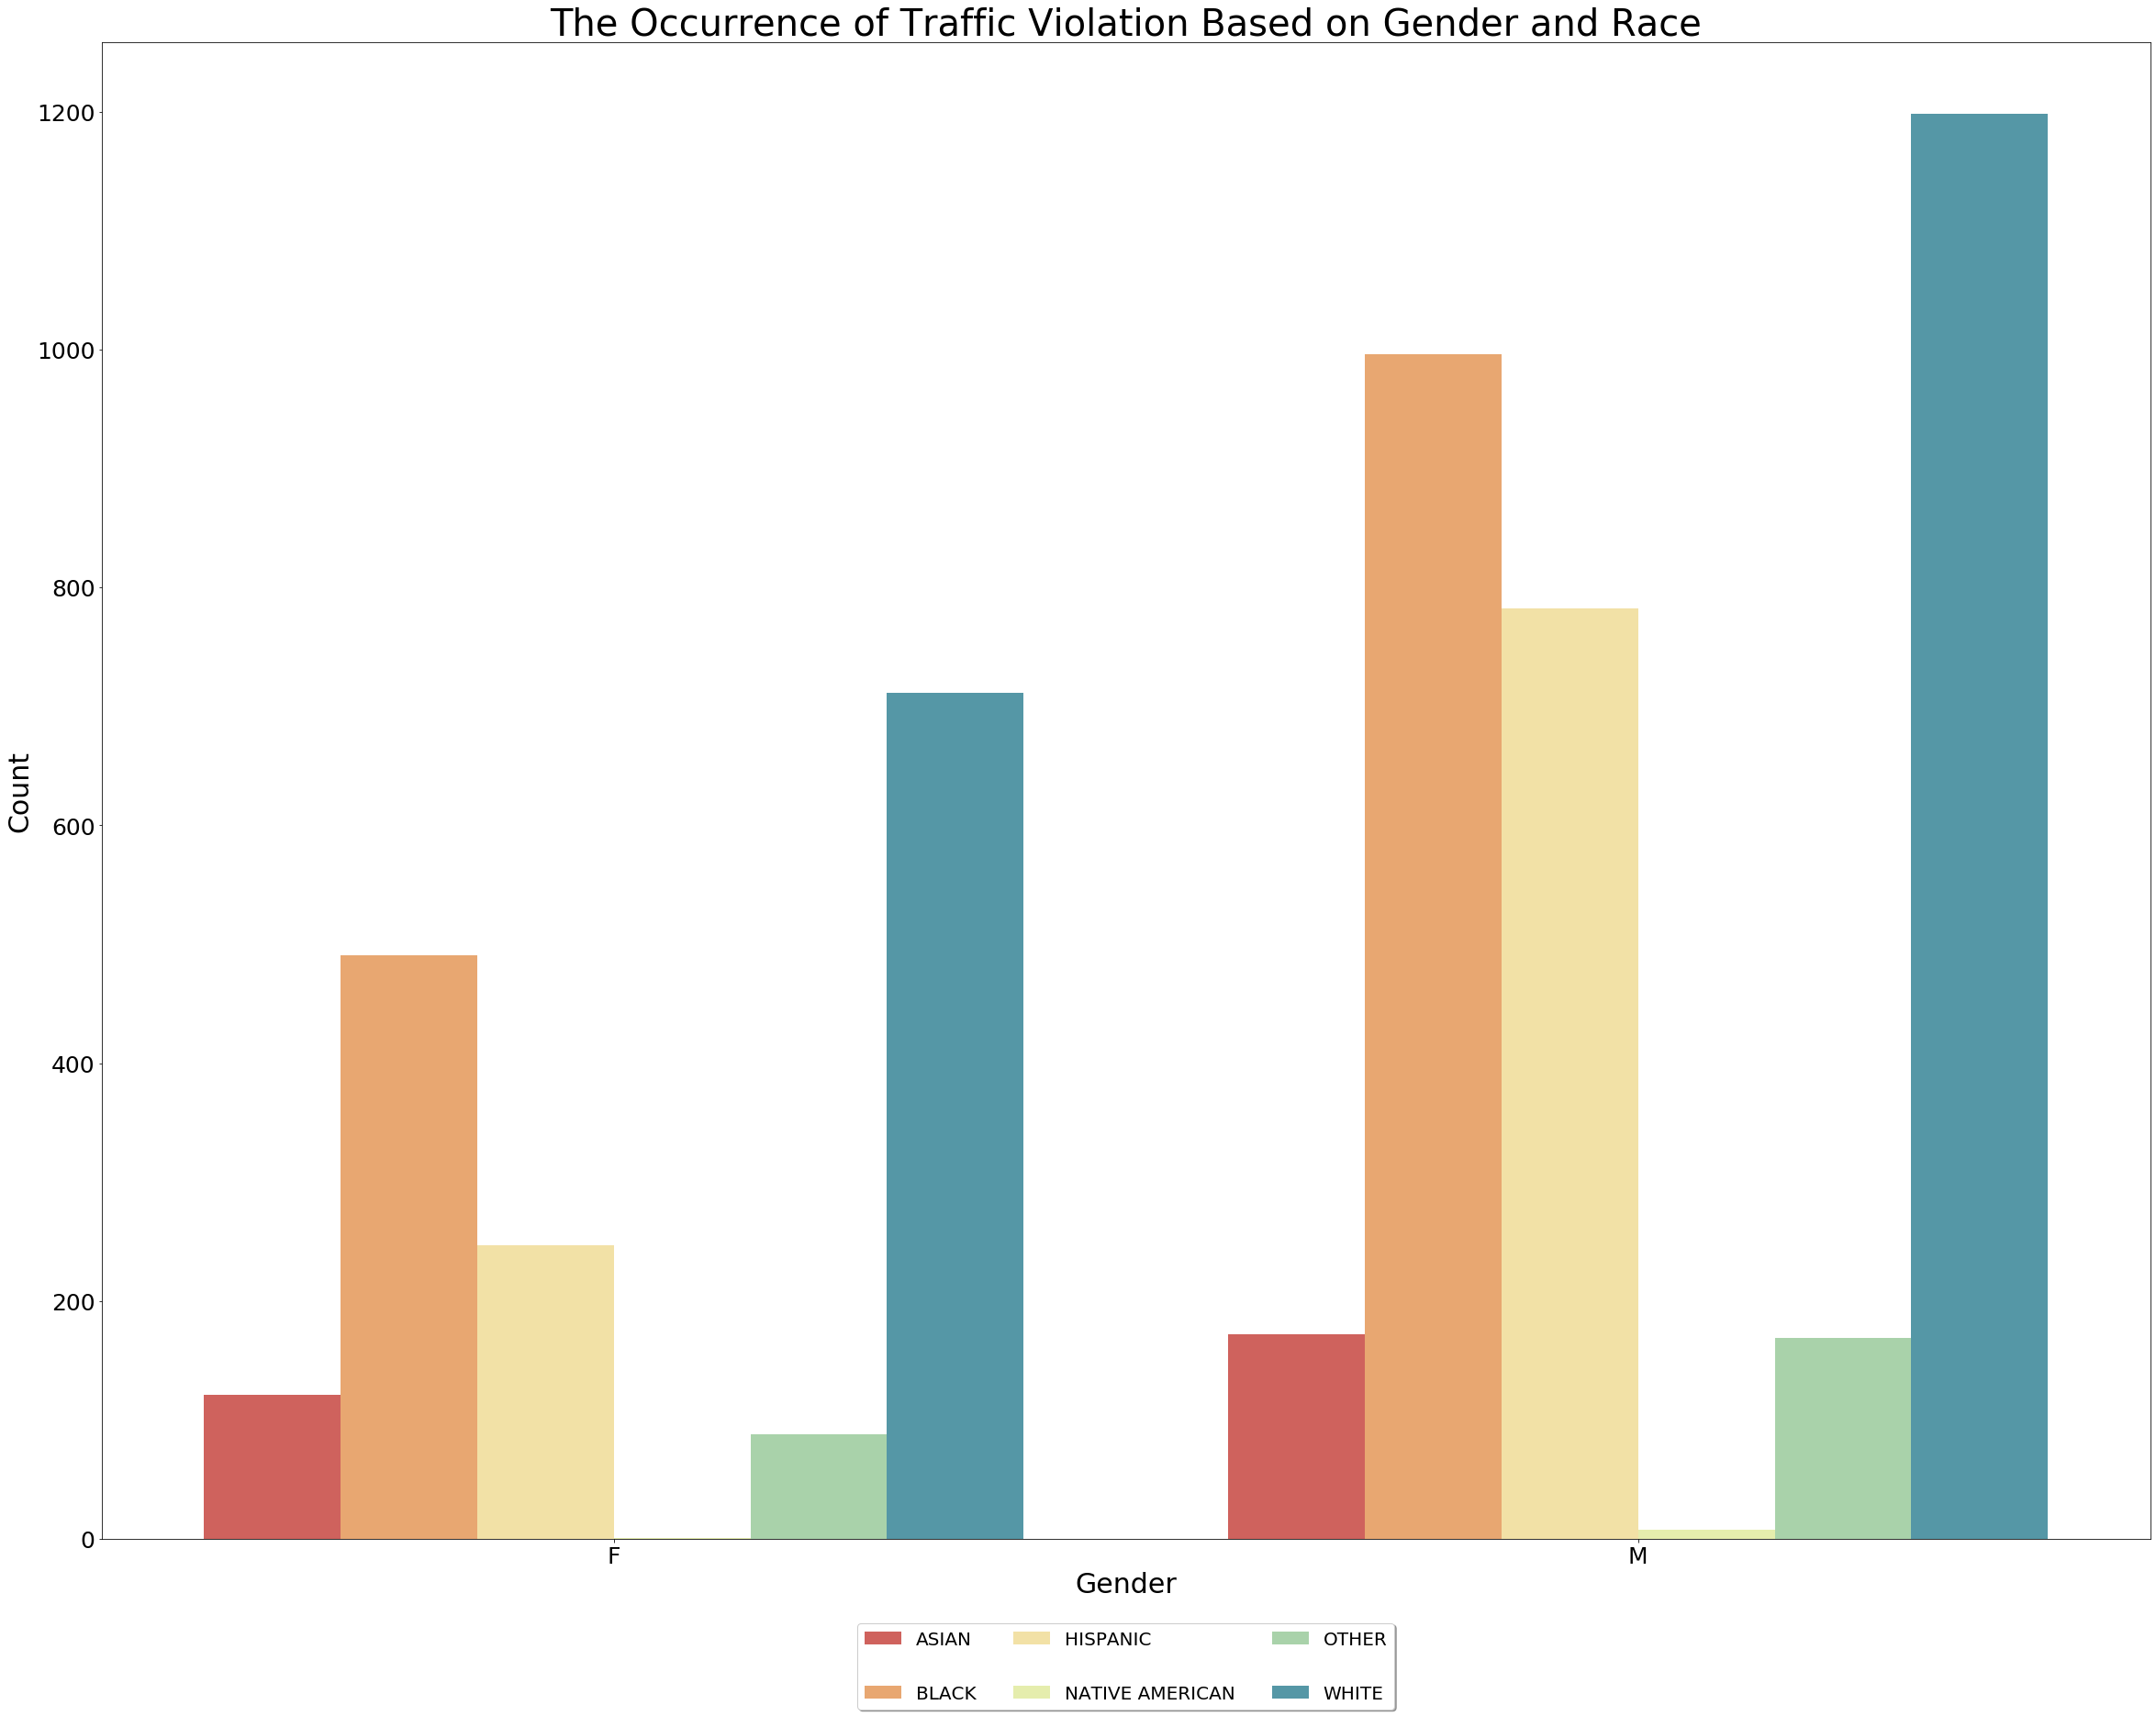

In [157]:
gr_df = sam.copy()
gr_df["count"] = 1

aggregation_functions = {'count': 'sum'}
nd = gr_df.groupby(['Gender', 'Race']).aggregate(aggregation_functions)

# Setting up the plot and dimension
fig, axs = plt.subplots() 
fig.set_figheight(30)
fig.set_figwidth(40)

b1 = sns.barplot(x="Gender", y ="count", hue="Race", palette = "Spectral", data=nd.reset_index(), ax = axs)
b1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, labelspacing=2, fontsize = 20)

b1.set_title("The Occurrence of Traffic Violation Based on Gender and Race", fontsize = 40)
b1.set_ylabel("Count", fontsize = 30)
b1.set_xlabel("Gender", fontsize = 30)
b1.tick_params(axis='both', labelsize=25)

plt.show()

# Heatmap Exploring the Occurrence based on the Hours

In [158]:
sam["hour"] = [t.hour for t in sam["Time Of Stop"]]
cut = pd.cut(sam["hour"], bins = [0,2,4,6,8,10,12,14,16,18,20,22,24], 
             labels = [1,2,3,4,5,6,7,8,9,10,11,12], right = False)
sam["cut"] = cut

In [159]:
df_copy = sam.copy()
df_copy['count'] = 1
hr_map = generate_map()

hm_fg = []
hr = 0
for ind in range(12):
    temp_name = "Hours " + str(hr) + " to " + str(hr + 1)
    hm_fg.append(folium.FeatureGroup(name = temp_name, show= True if ind == 0 else False))
    hr += 2


# Group time together to have more during a specifc set of hours\
for index in range(12):    
    temp = df_copy[df_copy["cut"] == index + 1]
    HeatMap(data=temp[['Latitude', 'Longitude', 'count']]
                .groupby(['Latitude', 'Longitude', 'count'])
                .sum()
                .reset_index()
                .values.tolist(), 
                radius=8, max_zoom=13).add_to(hm_fg[index])
    
for fg in hm_fg:
    fg.add_to(hr_map)
        
    
folium.LayerControl().add_to(hr_map)

hr_map

`You can filter what time the heatmap is showing using the layer tool at the top right corner of the map.`

In [160]:
time_map = generate_map()
df_hour_list = []
for hour in df_copy["cut"].sort_values().unique():
    df_hour_list.append(df_copy.loc[df_copy.hour == hour, ['Latitude', 'Longitude', 'count']]
                        .groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist())

HeatMapWithTime(df_hour_list, radius=8, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, 
                min_opacity=0.5, max_opacity=0.8, use_local_extrema=True, auto_play=True).add_to(time_map)

folium.LayerControl().add_to(time_map)

time_map

# Heatmap of All of the Traffic Violation

In [161]:
df_copy = sam.copy()
df_copy['count'] = 1
base_map = generate_map()

HeatMap(data=df_copy[['Latitude', 'Longitude', 'count']]
            .groupby(['Latitude', 'Longitude', 'count'])
            .sum()
            .reset_index()
            .values.tolist(), 
            radius=8, max_zoom=13).add_to(base_map)

folium.LayerControl().add_to(base_map)

base_map

# Exploring Race and The Violation Type

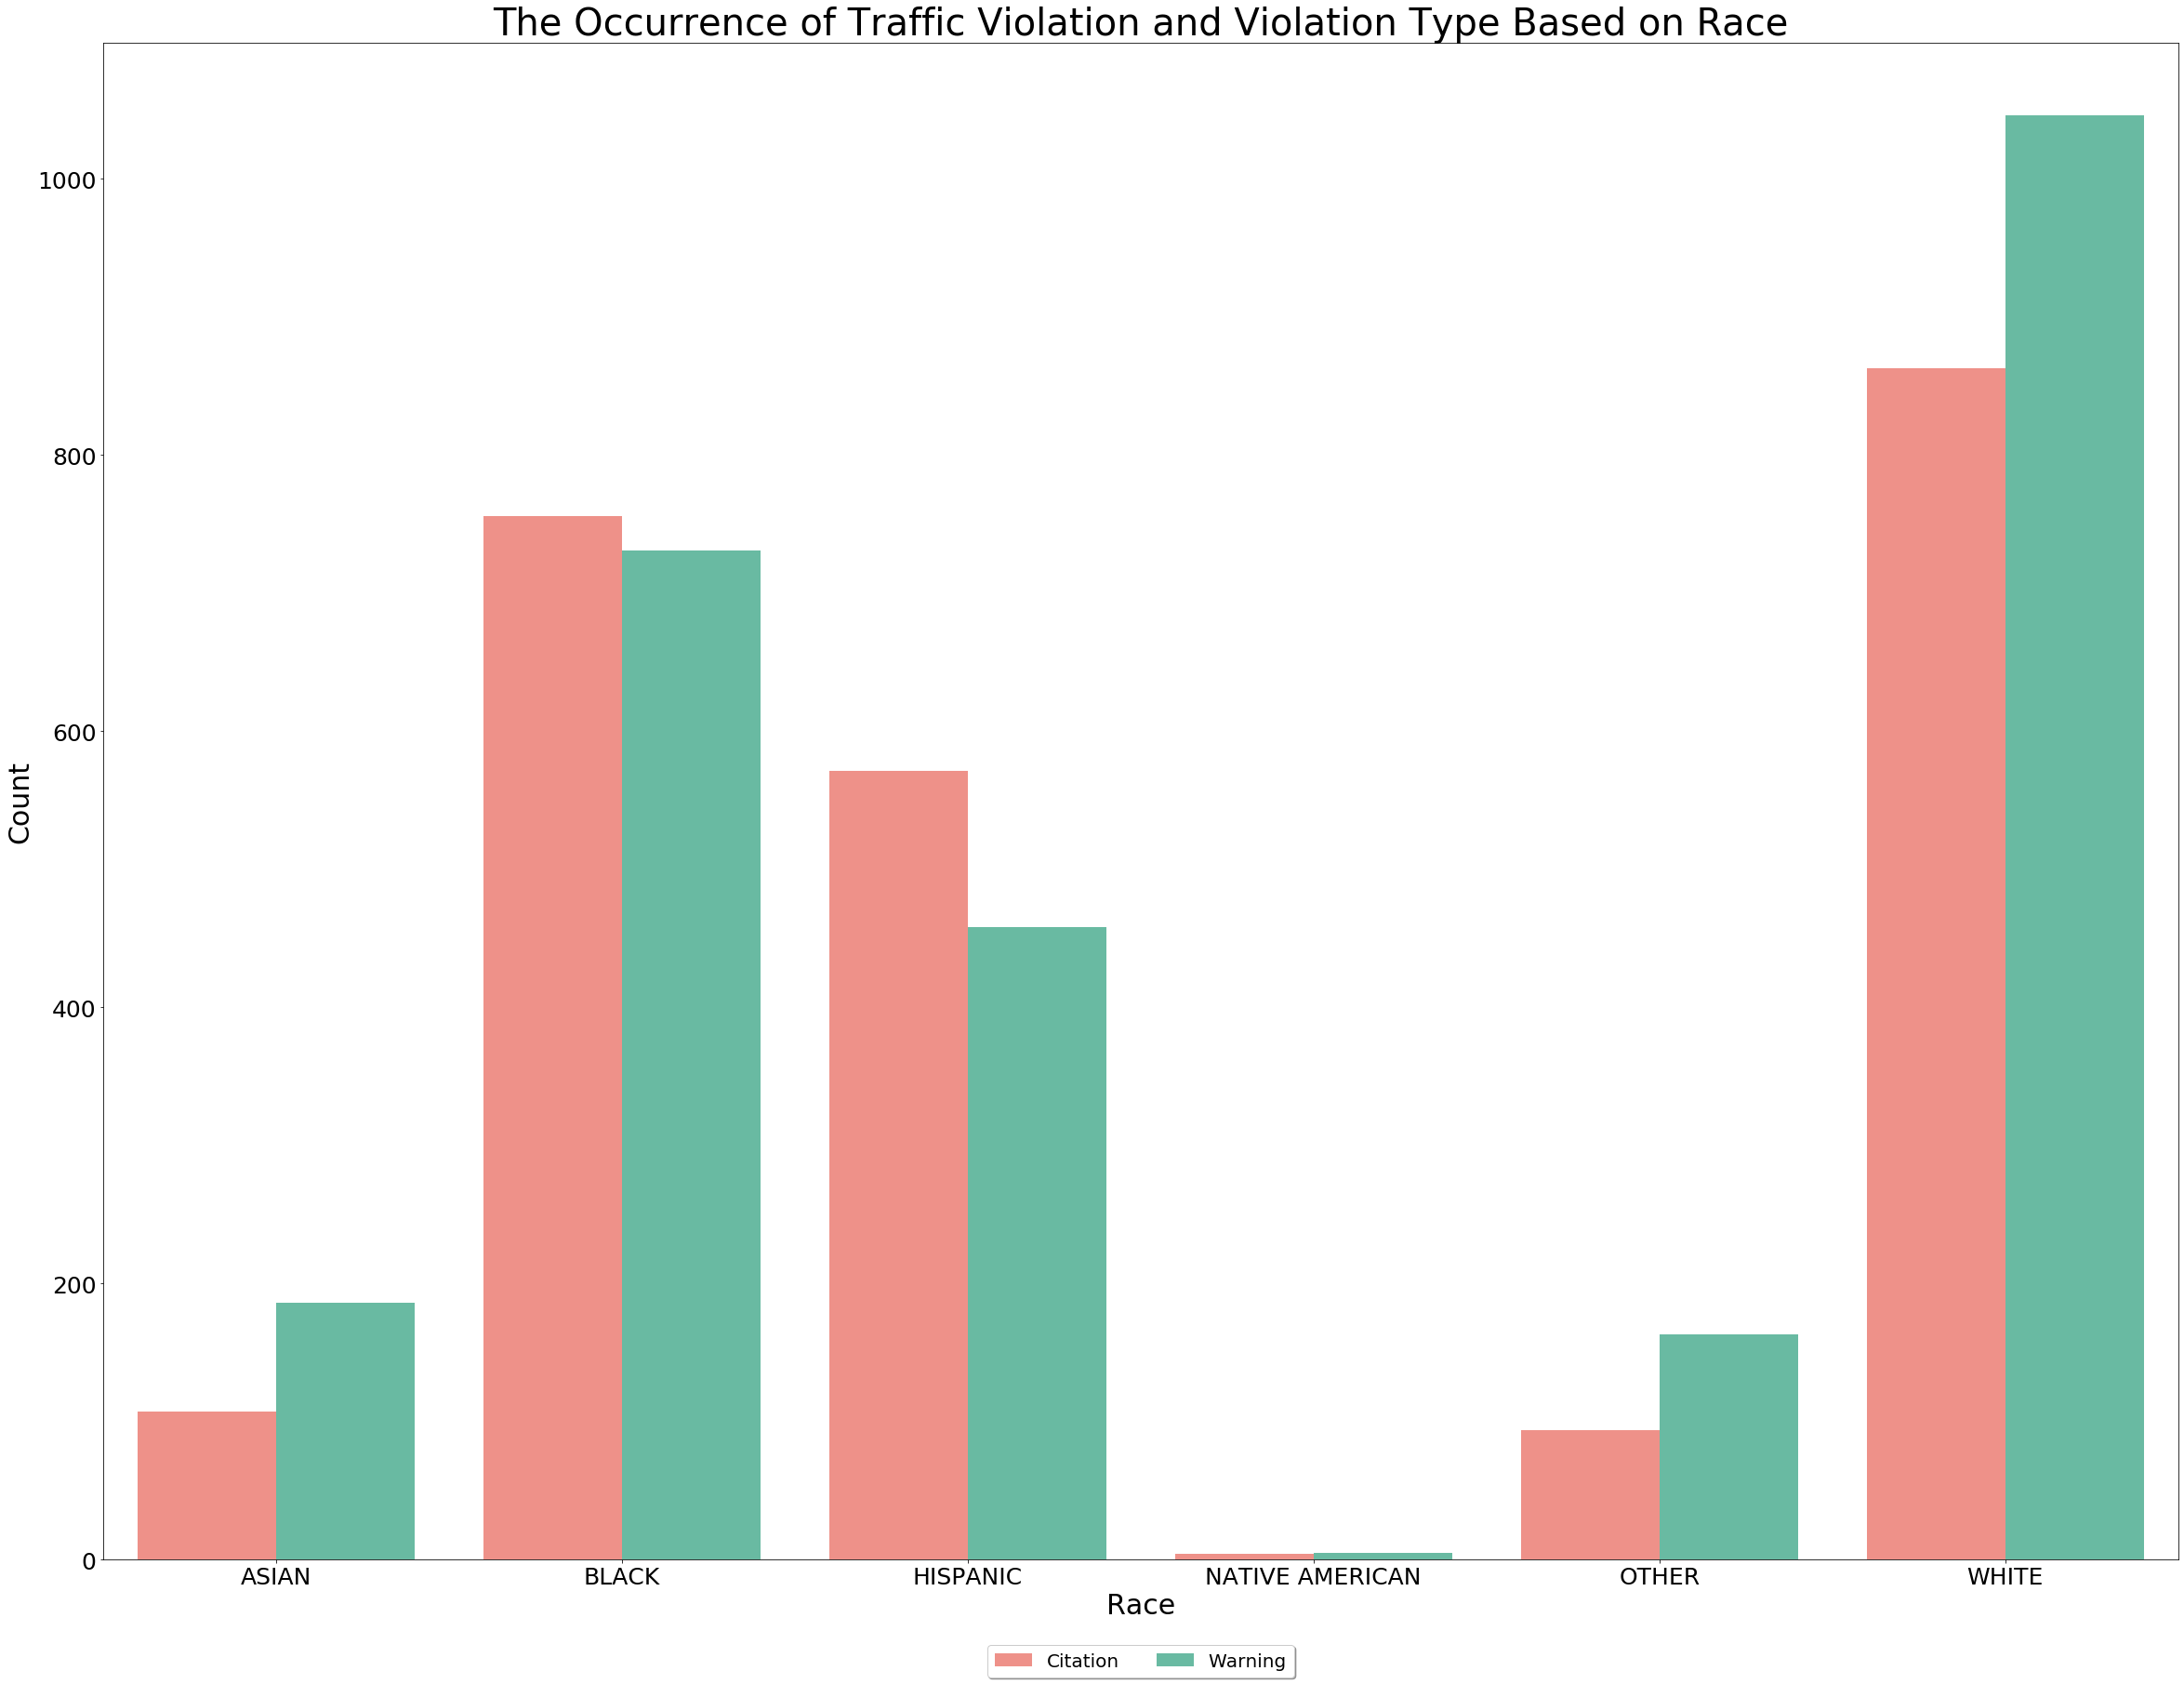

In [162]:
rv = sam.copy()
rv["count"] = 1

aggregation_functions = {'count': 'sum'}
nd = rv.groupby(['Race', 'Violation Type']).aggregate(aggregation_functions)

# Setting up the plot and dimension
fig, axs = plt.subplots() 
fig.set_figheight(30)
fig.set_figwidth(40)

r1 = sns.barplot(x="Race", y ="count", hue="Violation Type", palette = ["#ff8378", "#5bc7a7"], data=nd.reset_index(), ax = axs)
r1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, labelspacing=2, fontsize = 20)

r1.set_title("The Occurrence of Traffic Violation and Violation Type Based on Race", fontsize = 40)
r1.set_ylabel("Count", fontsize = 30)
r1.set_xlabel("Race", fontsize = 30)
r1.tick_params(axis='both', labelsize=25)

plt.show()

# Exploring Gender and Violation Type

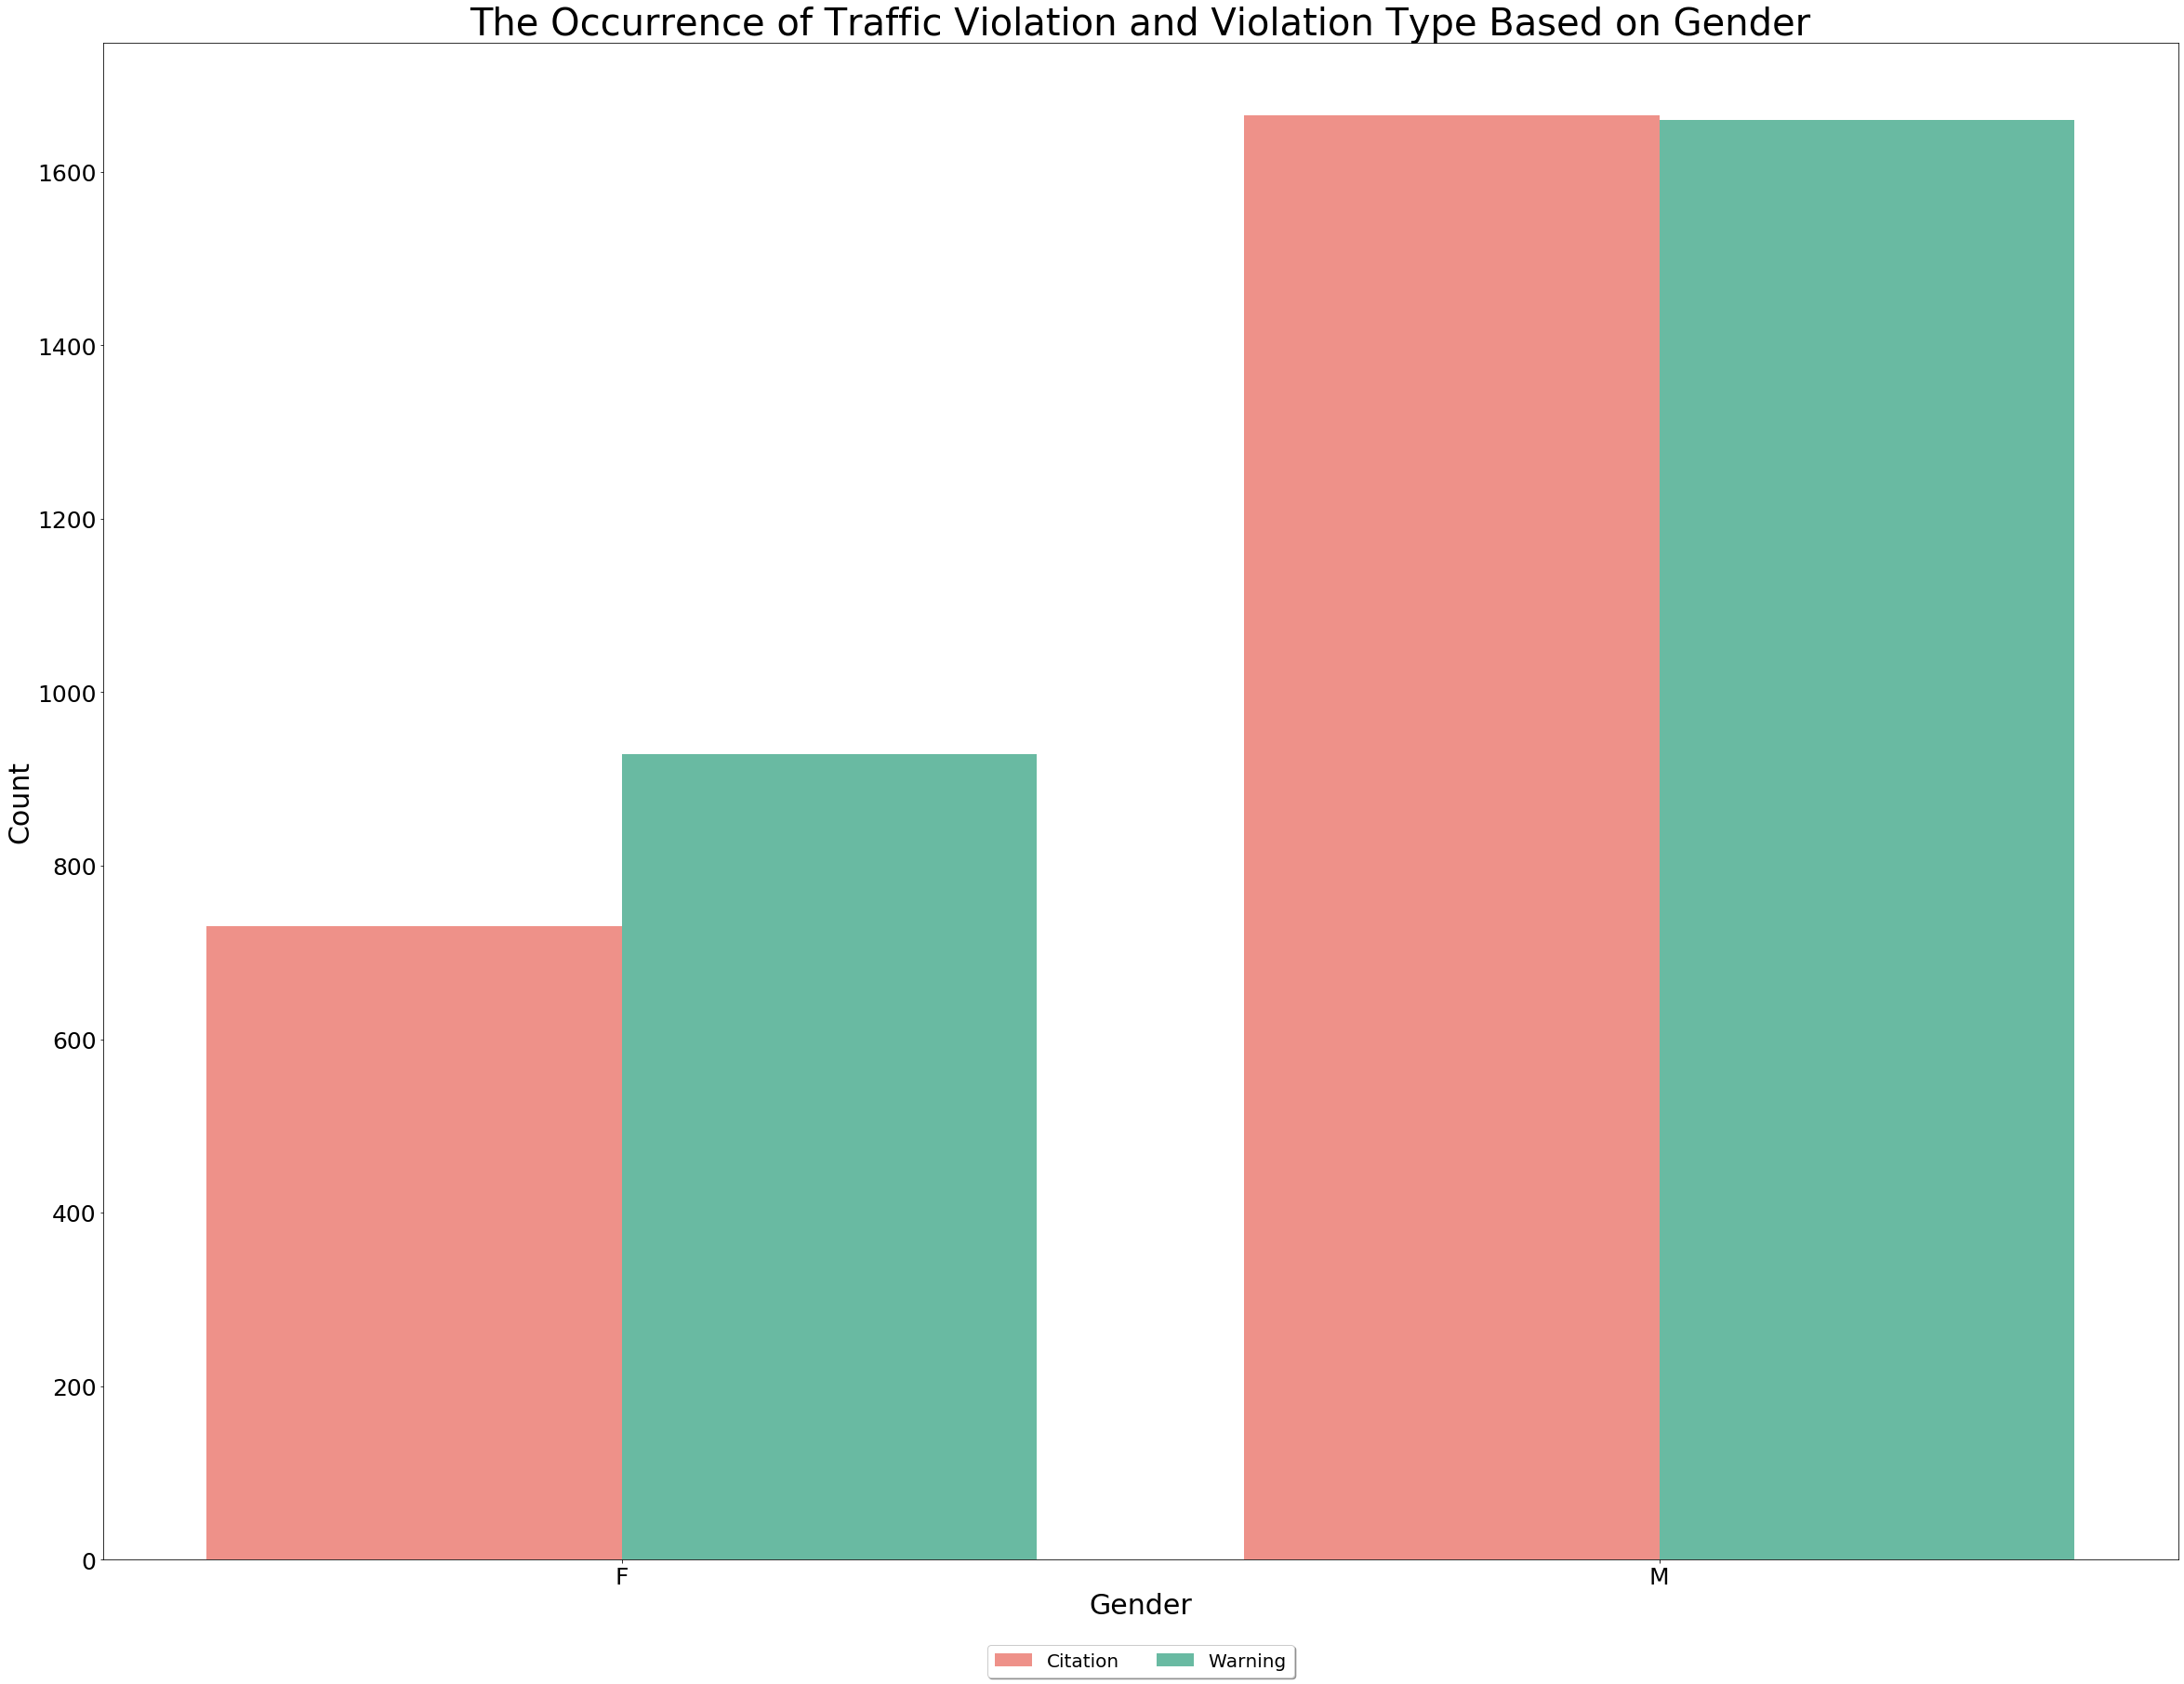

In [163]:
gv = sam.copy()
gv["count"] = 1

aggregation_functions = {'count': 'sum'}
nd = gv.groupby(['Gender', 'Violation Type']).aggregate(aggregation_functions)

# Setting up the plot and dimension
fig, axs = plt.subplots() 
fig.set_figheight(30)
fig.set_figwidth(40)

g1 = sns.barplot(x="Gender", y ="count", hue="Violation Type", palette = ["#ff8378", "#5bc7a7"], data=nd.reset_index(), ax = axs)
g1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3, labelspacing=2, fontsize = 20)

g1.set_title("The Occurrence of Traffic Violation and Violation Type Based on Gender", fontsize = 40)
g1.set_ylabel("Count", fontsize = 30)
g1.set_xlabel("Gender", fontsize = 30)
g1.tick_params(axis='both', labelsize=25)

plt.show()

# Can We Predict What Violation Type Someone Can Get?
<hr>

In [164]:
data_reg = sam.copy()

vt = {"Warning": 1,
      "Citation": 2,
      "ESERO": 3,
      "SERO": 4}

data_reg["violation_type_num"] = [vt[v] for v in data_reg["Violation Type"]]
data_reg = pd.get_dummies(data_reg, columns = ["Gender"])
data_reg = pd.get_dummies(data_reg, columns = ["Race"])
data_reg["Race_NATIVE"] = data_reg["Race_NATIVE AMERICAN"] # Rename the column Race_NATIVE AMERICAN to Race_NATIVE

data_reg.head()

Date Of Stop Time Of Stop                                        SubAgency  \
0   2016-05-01     23:08:00                            4th district, Wheaton   
1   2017-11-30     01:14:00                      3rd district, Silver Spring   
2   2012-05-24     10:48:00                      3rd district, Silver Spring   
3   2012-10-18     03:30:00                      3rd district, Silver Spring   
4   2012-02-16     07:47:00  6th district, Gaithersburg / Montgomery Village   

                                         Description  \
0  DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEFO...   
1  DRIVING VEHICLE IN EXCESS OF REASONABLE AND PR...   
2  DRIVER USING HANDS TO USE HANDHELD TELEPHONE W...   
3  DRIVING TO DRIVE MOTOR VEHICLE ON HIGHWAY WITH...   
4  EXCEEDING MAXIMUM SPEED: 34 MPH IN A POSTED 25...   

                             Location   Latitude  Longitude Violation Type  \
0        GEORGIA AVE AT GLENALLAN AVE  39.063522 -77.055263       Citation   
1        RANDOLPH ROAD AT TAMARACK RD  39.067270 -76.984982       Citation   
2      WAYNE AVE / COLESVILLE RD, W/B  38.995165 -77.031199       Citation   
3        COLUMBIA PIKE AT LORRAIN AVE  38.998501 -77.026377       Citation   
4  GAME PRESERVE RD N/B (11400 BLOCK)  39.157287 -77.239419       Citation   

   hour cut  violation_type_num  Gender_F  Gender_M  Race_ASIAN  Race_BLACK  \
0    23  12                   2         0         1           0           0   
1     1   1                   2         0         1           0           1   
2    10   6                   2         1         0           0           0   
3     3   2                   2         0         1           0           1   
4     7   4                   2         1         0           0           0   

   Race_HISPANIC  Race_NATIVE AMERICAN  Race_OTHER  Race_WHITE  Race_NATIVE  
0              1                     0           0           0            0  
1              0                     0           0           0            0  
2              1                     0           0           0            0  
3              0                     0           0           0            0  
4              1                     0           0           0            0

In [165]:
distlr = sm.ols(formula = 'violation_type_num ~ hour + Race_ASIAN + Race_BLACK + + Race_WHITE + Race_HISPANIC + Race_OTHER + Race_NATIVE + Gender_F + Gender_M', data = data_reg).fit()   

distlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     violation_type_num   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     15.66
Date:                Mon, 16 Dec 2019   Prob (F-statistic):           1.91e-20
Time:                        03:30:21   Log-Likelihood:                -3559.3
No. Observations:                4984   AIC:                             7135.
Df Residuals:                    4976   BIC:                             7187.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9055      0.019     48.342      0.000       0.869       0.942
hour             -0.0058      0.001     -5.846      0.000      -0.008      -0.004
Race_ASIAN        0.0812      0.035      2.291      0.022       0.012       0.151
Race_BLACK        0.2167      0.028      7.747      0.000       0.162       0.272
Race_WHITE        0.1632      0.028      5.926      0.000       0.109       0.217
Race_HISPANIC     0.2607      0.029      9.011      0.000       0.204       0.317
Race_OTHER        0.0773      0.037      2.114      0.035       0.006       0.149
Race_NATIVE       0.1064      0.140      0.758      0.448      -0.169       0.382
Gender_F          0.4277      0.013     34.122      0.000       0.403       0.452
Gender_M          0.4779      0.011     41.863      0.000       0.455       0.500
==============================================================================
Omnibus:                    18321.544   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              761.490
Skew:                           0.075   Prob(JB):                    4.41e-166
Kurtosis:                       1.091   Cond. No.                     1.01e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.09e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

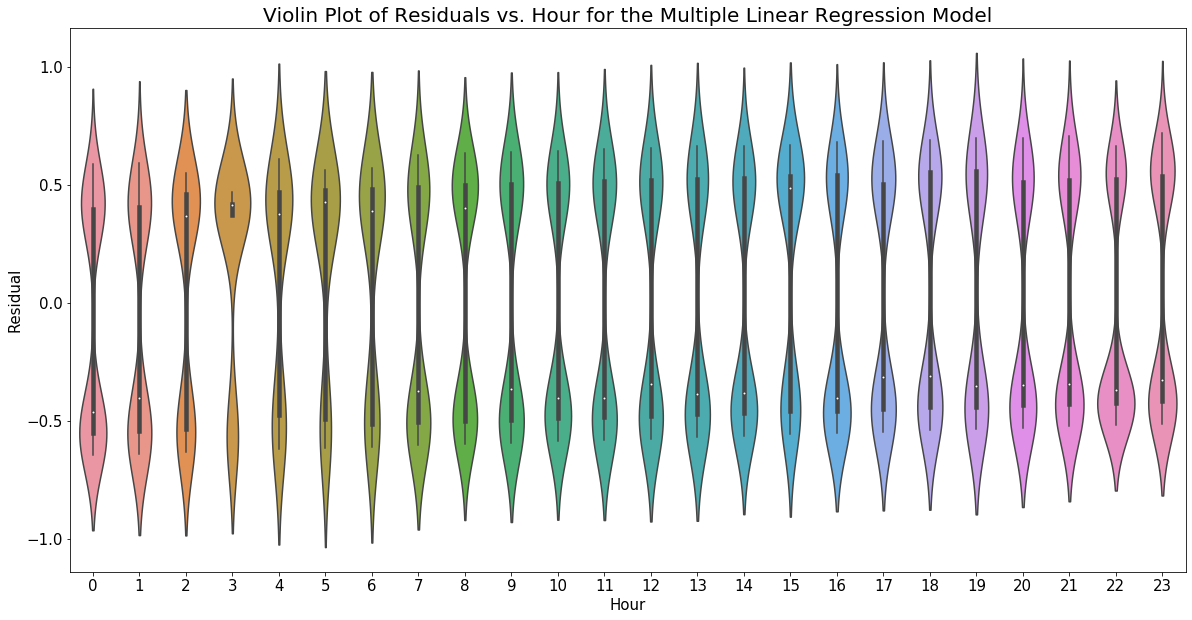

In [166]:
# Setting up the plot and dimension
fig, axs = plt.subplots(nrows = 1)
fig.set_figheight(10)
fig.set_figwidth(20)

predict = distlr.predict({"hour": data_reg["hour"],"Gender_F": data_reg['Gender_F'], 
                          "Gender_M": data_reg['Gender_M'], "Race_ASIAN": data_reg['Race_ASIAN'],
                          "Race_BLACK": data_reg['Race_BLACK'], "Race_WHITE": data_reg['Race_WHITE'],
                          "Race_HISPANIC": data_reg['Race_HISPANIC'], "Race_OTHER": data_reg['Race_OTHER'],
                          "Race_NATIVE": data_reg['Race_NATIVE']})

resid = data_reg["violation_type_num"] - predict
d1 = sns.violinplot(x = data_reg["hour"], y = resid, ax = axs)
d1.set_title("Violin Plot of Residuals vs. Hour for the Multiple Linear Regression Model", fontsize = 20)
d1.set_ylabel("Residual", fontsize = 15)
d1.set_xlabel("Hour", fontsize = 15)
d1.tick_params(axis='both', labelsize=15)

plt.show()

In our model, it predicted value between 1 and 2 (Technically also 3 for ESERO and 4 for SERO, but they are very rare), meaning that it can predict a decimal value such as 1.5. This does not make sense because there are only two options, either 1 for warning or 2 for citation. In order to make sense of the prediction, we rounded any predictions less than 1.5 to 1 and any predictions greater than or equal to 1.5 to 2.

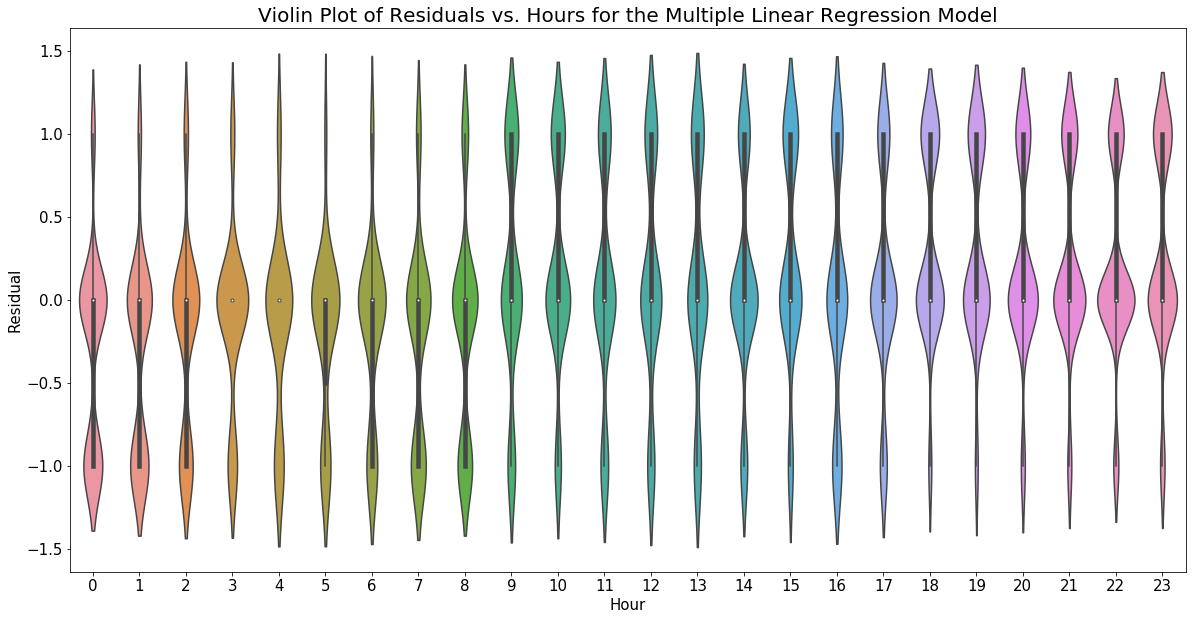

In [167]:
rounded = []
for p in predict:
    if p < 1.5:
        rounded.append(1)
    elif p < 2.5: 
        rounded.append(2)
    elif p < 3.5:
        rounded.append(3)
    else:
        rounded.append(4)
        
# Setting up the plot and dimension
fig, axs = plt.subplots(nrows = 1)
fig.set_figheight(10)
fig.set_figwidth(20)        

resid = data_reg["violation_type_num"] - rounded
d2 = sns.violinplot(x = data_reg["hour"], y = resid, ax = axs)
d2.set_title("Violin Plot of Residuals vs. Hours for the Multiple Linear Regression Model", fontsize = 20)
d2.set_ylabel("Residual", fontsize = 15)
d2.set_xlabel("Hour", fontsize = 15)
d2.tick_params(axis='both', labelsize=15)

plt.show()

In our violinplot of the residuals vs hours for the multiple linear regression model, a residual value of 0 means that our model predicted the correct violation type and a value of 1 or -1 means that our model predicted wrong. 

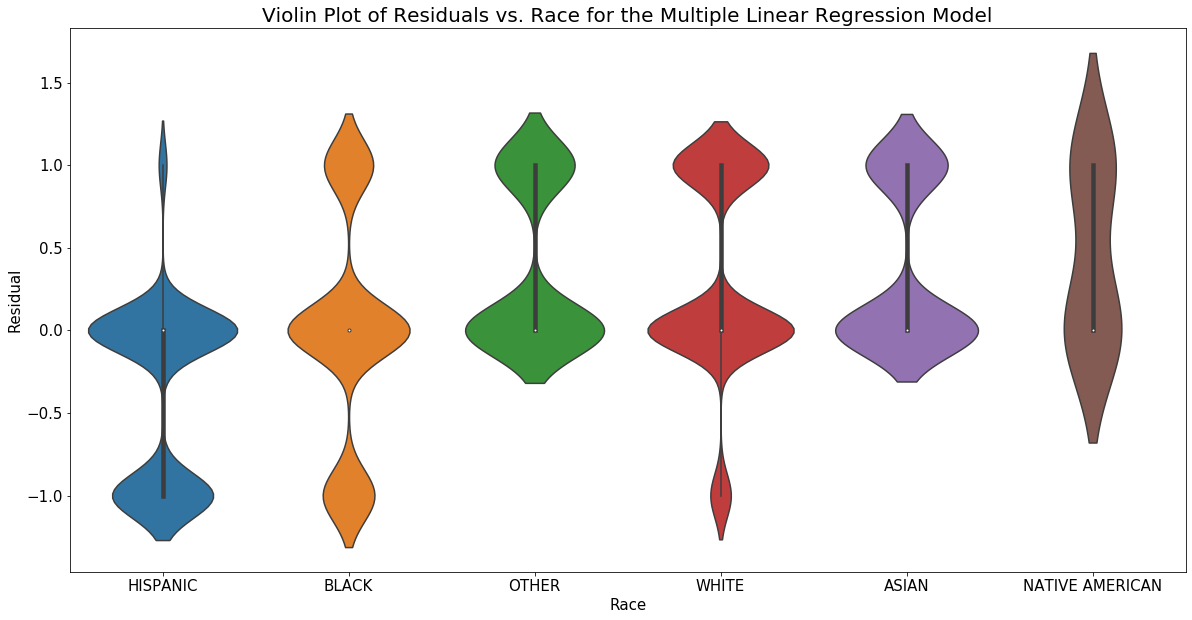

In [168]:
# Setting up the plot and dimension
fig, axs = plt.subplots(nrows = 1)
fig.set_figheight(10)
fig.set_figwidth(20)        

d2 = sns.violinplot(x = sam["Race"], y = resid, ax = axs)
d2.set_title("Violin Plot of Residuals vs. Race for the Multiple Linear Regression Model", fontsize = 20)
d2.set_ylabel("Residual", fontsize = 15)
d2.set_xlabel("Race", fontsize = 15)
d2.tick_params(axis='both', labelsize=15)

plt.show()

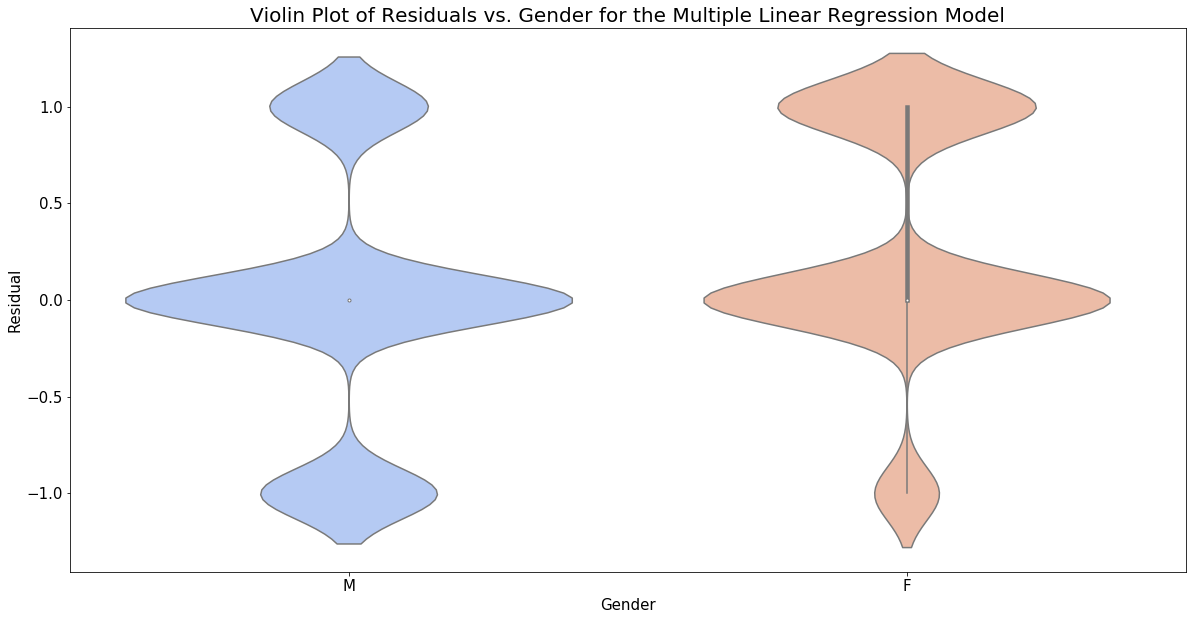

In [169]:
# Setting up the plot and dimension
fig, axs = plt.subplots(nrows = 1)
fig.set_figheight(10)
fig.set_figwidth(20)        

d2 = sns.violinplot(x = sam["Gender"], y = resid, palette = "coolwarm",ax = axs)
d2.set_title("Violin Plot of Residuals vs. Gender for the Multiple Linear Regression Model", fontsize = 20)
d2.set_ylabel("Residual", fontsize = 15)
d2.set_xlabel("Gender", fontsize = 15)
d2.tick_params(axis='both', labelsize=15)

plt.show()

# Conclusion:

![](idiots.jpg)

<b>Drive Safe Out There!</b>